In [42]:
import cv2
import torch
from torch import optim
from torch.autograd.functional import jacobian
from PIL import Image
import OpenEXR, Imath
import numpy as np
from matplotlib import pyplot as plt
import time
import skfmm
from scipy.optimize import minimize, Bounds

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
def exr_to_np(path):
    y_resolution = 540
    x_resolution = 810
    pt = Imath.PixelType(Imath.PixelType.FLOAT)
    
    rgb_exr = OpenEXR.InputFile(path)
    rgb_dw = rgb_exr.header()['dataWindow']
    rgb_size = (rgb_dw.max.x - rgb_dw.min.x + 1, rgb_dw.max.y - rgb_dw.min.y + 1)
    r_str = rgb_exr.channel('R', pt)
    g_str = rgb_exr.channel('G', pt)
    b_str = rgb_exr.channel('B', pt)
    rgb_img = np.zeros((y_resolution, x_resolution, 3))
    r_ch = Image.frombytes("F", rgb_size, r_str)
    g_ch = Image.frombytes("F", rgb_size, g_str)
    b_ch = Image.frombytes("F", rgb_size, b_str)
    rgb_img[: ,:, 2] = np.array(r_ch.getdata()).reshape(y_resolution, x_resolution)
    rgb_img[: ,:, 1] = np.array(g_ch.getdata()).reshape(y_resolution, x_resolution)
    rgb_img[: ,:, 0] = np.array(b_ch.getdata()).reshape(y_resolution, x_resolution)
    min_val = rgb_img.min()
    max_val = rgb_img.max() 
    rgb_img = ((rgb_img - min_val)/(max_val - min_val) * 255.0).astype(np.uint8)
    return rgb_img

In [4]:
def depth_exr_to_np(path):
    y_resolution = 540
    x_resolution = 810
    pt = Imath.PixelType(Imath.PixelType.FLOAT)
    
    depth_exr = OpenEXR.InputFile(path)
    depth_dw = depth_exr.header()['dataWindow']
    depth_size = (depth_dw.max.x - depth_dw.min.x + 1, depth_dw.max.y - depth_dw.min.y + 1)
    depth_str = depth_exr.channel('R', pt)
    depth = Image.frombytes("F", depth_size, depth_str)
    depth_img = np.array(depth.getdata()).reshape(y_resolution, x_resolution)
    depth_img = depth_img * 1000.0
    return depth_img

In [5]:
def threshold(img, v_min, v_max):
    '''
    threshold an img using v_min and v_max; img.shape[2] = v_min.shape[0] = v_max.shape[0]
    '''
    H, W, C = img.shape
    mask =  np.ones((H, W))
    for i in range(C):
        mask_i_1 = img[:, :, i] > v_min[i]
        mask_i_2 = img[:, :, i] < v_max[i]
        mask_i = np.logical_and(mask_i_1, mask_i_2)
        mask = np.logical_and(mask, mask_i)
    return mask

In [ ]:
def sign_nozero(p):
    '''
    Similar to np.sign but output is 1 if value is zero
    '''
    p = p.astype(float)
    p[p == 0] += 0.001

In [92]:
class indi_pt_tracker:
    def __init__(self, H, W, l, cuda=False):
        self.H = H
        self.W = W
        self.l = l
        self.lam = 10.
        self.cuda = cuda
        if cuda == True:
            self.device='cuda'
        else:
            self.device='cpu'
        
    def set_obs(self, mask, rgb_np=None, depth_np=None):
#         plt.imshow(mask)
#         plt.show()
        mask = (~mask).astype(np.uint8)
        phi = np.where(mask, 0, -1) + 0.5
        dist = skfmm.distance(phi, dx = 1)
#         plt.imshow(dist)
#         plt.show()
        dist = dist - dist.min() # - 1
        sobelx = cv2.Sobel(dist,cv2.CV_64F,1,0,ksize=-1)/30.56
        sobely = cv2.Sobel(dist,cv2.CV_64F,0,1,ksize=-1)/30.56
        plt.imshow(sobelx)
        plt.show()
        
        self.mask = mask
        self.dist = dist
        self.dist_x = sobelx
        self.dist_y = sobely
                
        self.rgb_np = rgb_np
        self.depth_np = depth_np
    
    def p2ang(self, p):
        '''
        Input: p: numpy array (Np, 2)
        Output: ang: numpy array (Ne)
        '''
        p = p.astype(float)
        dx = p[:-1, 1] - p[1:, 1]
        dy = p[:-1, 0] - p[1:, 0]
        ang_0_pi = np.arccos(dx/(np.square(dx)+np.square(dy)))
        dy[ang_0_pi==0] += 0.01 # singular value for ang_0_pi = 0 or anf_0_pi = pi
        ang = np.sign(dy)*ang_0_pi
        return ang
    
    def hard_constrain(self, p):
        '''
        p: numpy array (Np,2)
        '''
        p = np.maximum(p, np.zeros_like(p))
        p[:,0] = np.minimum(p[:,0], np.ones(p[:,0].shape, dtype=int)*(self.H-1))
        p[:,1] = np.minimum(p[:,1], np.ones(p[:,1].shape, dtype=int)*(self.W-1))
        return p
    
    def set_init(self, p):
        '''
        p: numpy array (Np,2)
        '''
        self.p = p
        self.ang = self.p2ang(self.p)
        lb = np.zeros(p.shape[0]*2)
        ub = np.ones(p.shape[0]*2)
        ub[0::2] = self.H-1
        ub[1::2] = self.W-1
        self.bound = Bounds(lb, ub)
#         for i in range(p.shape[0]//2):
#             self.bound.append((0,self.H-1))
#             self.bound.append((0,self.W-1))
    
    def obj_fn(self, p):
        '''
        p: numpy array (2*Np,)
        '''
        loss = 0
        p = p.reshape(-1,2).astype(int)
        print('In obj fn')
        print(p)
        p = self.hard_constrain(p)
        loss += np.sum(np.square(self.dist[p[:,0], p[:,1]]))
#         prev_edge = (self.p[1:] - self.p[:-1])
#         prev_edge = prev_edge/np.linalg.norm(prev_edge, axis=1)[:, None]
#         curr_edge = (p[1:] - p[:-1])/l
#         curr_edge = curr_edge/np.linalg.norm(curr_edge, axis=1)[:, None]
#         ang = np.arccos(prev_edge * curr_edge)
#         d_ang = self.p2ang(p.reshape(-1,2)) - self.ang
#         loss += np.sum(self.lam*np.square(d_ang))
        return loss
    
    def jac_fn(self, p):
        '''
        p: numpy array (2*Np,)
        '''
        p = p.reshape(-1,2).astype(int)
        p = self.hard_constrain(p)
        # Jacobian for distance residuals
        J_D = np.zeros(p.shape)
        J_D[:, 1] = self.dist_x[p[:, 0], p[:, 1]]
        J_D[:, 0] = self.dist_y[p[:, 0], p[:, 1]]
        J_D = self.dist[p[:, 0], p[:, 1]][:, None]*J_D
        
        # Jacobian for the angle change
#         J_ang = np.zeros(p.shape)
#         dx = p[:-1, 1] - p[1:, 1]
#         dy = p[:-1, 0] - p[1:, 0]
#         l = np.square(dx)+np.square(dy)
#         d_ang = self.p2ang(p) - self.ang
#         J_ang[1:, 0] = -2*self.lam*d_ang*dx/l
#         J_ang[1:, 1] = 2*self.lam*d_ang*dy/l
#         J_ang[:-1,0] = 2*self.lam*d_ang*dx/l
#         J_ang[:-1,1] = -2*self.lam*d_ang*dy/l
        
#         return ((J_D+J_ang).reshape(-1))/4
        print('In jac fn')
        print(J_D)
        return J_D.reshape(-1)
    
    def fixed_len(self, p):
        '''
        p: numpy array (2*Np,)
        '''
        p = p.reshape(-1,2)
        return np.sum(np.square(np.linalg.norm(p[1:] - p[:-1], axis=1) - self.l))
    
    def fixed_len_jac(self, p):
        '''
        p: numpy array (2*Np,)
        '''
        p = p.reshape(-1,2)
        dp = p[1:] - p[:-1]
        dp_norm = np.linalg.norm(dp, axis=1)
        
        J = np.zeros_like(p)
        J[:-1, 0] += np.sign(dp_norm-self.l)*(p[:-1,0]-p[1:,0])/dp_norm
        J[:-1, 1] += np.sign(dp_norm-self.l)*(p[:-1,1]-p[1:,1])/dp_norm
        J[1:, 0] += np.sign(dp_norm-self.l)*(p[1:,0]-p[:-1,0])/dp_norm
        J[1:, 1] += np.sign(dp_norm-self.l)*(p[1:,1]-p[:-1,1])/dp_norm
        print('In constrain jac')
        print(J)
#         J = np.sign(dp_norm-self.l)[:, None] * J
        return J.reshape(-1)
    
    def step(self):
        p = self.p.copy().reshape(-1)
        cons = []
        fixed_len = {
            'type': 'eq',
            'fun': self.fixed_len,
            'jac': self.fixed_len_jac
        }
        cons.append(fixed_len)
        res = minimize(self.obj_fn, p, jac=self.jac_fn, constraints=cons, method='SLSQP')
        self.p = res.x.reshape(-1, 2)
        self.ang = self.p2ang(self.p)
        print(res)
        
    def vis(self, save_dir=None, idx=0):
        if self.rgb_np is not None:
            vis_img = self.rgb_np.copy()
        else:
            vis_img = np.zeros((self.H, self.W))

        radius = 5
        color = (255, 0, 0)
        thickness = 3

        for i in range(self.p.shape[0]):
            vis_img = cv2.circle(vis_img, (int(self.p[i][1]), int(self.p[i][0])), radius, color, thickness)
        plt.imshow(vis_img)
        if save_dir is not None:
            import pathlib
            pathlib.Path(save_dir).mkdir(parents=True, exist_ok=True)
            plt.savefig(save_dir+"frame_"+'{0:03d}'.format(idx)+".png", dpi=300)
        plt.show()

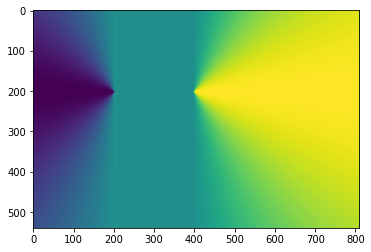

In obj fn
[[180 200]
 [180 220]
 [180 240]
 [180 260]
 [180 280]
 [180 300]
 [180 320]
 [180 340]
 [180 360]
 [180 380]
 [180 400]]
In jac fn
[[-2.29435191e+01 -3.50149909e-01]
 [-2.30366492e+01  2.26090234e-12]
 [-2.30366492e+01 -2.22765378e-12]
 [-2.30366492e+01 -3.32485639e-14]
 [-2.30366492e+01  2.26090234e-12]
 [-2.30366492e+01 -2.22765378e-12]
 [-2.30366492e+01 -3.32485639e-14]
 [-2.30366492e+01  2.26090234e-12]
 [-2.30366492e+01 -2.22765378e-12]
 [-2.30366492e+01  2.54735151e-12]
 [-2.29686933e+01  2.04019440e+00]]
In constrain jac
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
     fun: 5320.861485261004
     jac: array([-2.29435191e+01, -3.50149909e-01, -2.30366492e+01,  2.26090234e-12,
       -2.30366492e+01, -2.22765378e-12, -2.30366492e+01, -3.32485639e-14,
       -2.30366492e+01,  2.26090234e-12, -2.30366492e+01, -2.22765378e-12,
       -2.30366492e+01, -3.32485639e-14, -2.30366492e+01,  2.26090234e-12,
       -2.3036649

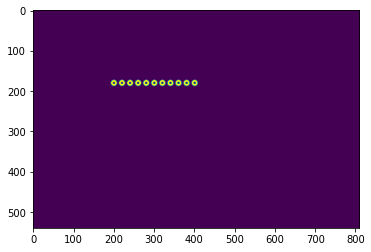

In [93]:
# sanity check for LSLQP
H = 540
W = 810
l = 20
simple_tracker = indi_pt_tracker(H, W, l, cuda=False)
q = np.zeros((11,2)).astype(int)
q[:, 0] = 180
q[:, 1] = np.arange(200, 401, 20)
simple_tracker.set_init(q)
mask = np.zeros((H, W), dtype=bool)
mask[200:205, 200:400] = True
simple_tracker.set_obs(mask)
simple_tracker.step()
simple_tracker.vis()